## Bring in the data and preview it

In [1]:
import os
import random
import numpy as np
import torch

def set_seed(seed= 24):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(24)

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [4]:
!unzip -q license-plate-dataset.zip -d data

In [5]:
#general purpose libraries
import os
import shutil
import math
import itertools
from glob import glob

#data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

#pytorch core libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#pytorch utilities
from torch.utils.data import Dataset, DataLoader

#TorchVision libraries
import torchvision
from torchvision import transforms
from torchvision.ops import generalized_box_iou
import torchvision.models as models

#Scikit-learn utilities
from sklearn.model_selection import train_test_split

In [6]:
#data paths
image_dir = 'data/archive/images/train'
label_dir = 'data/archive/labels/train'

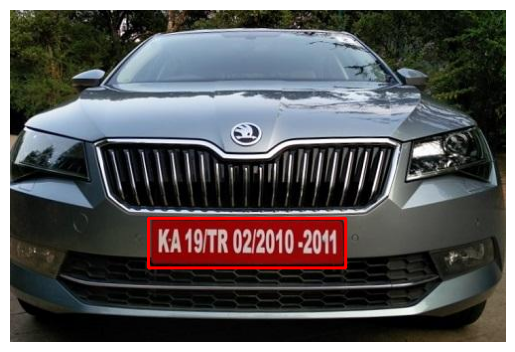

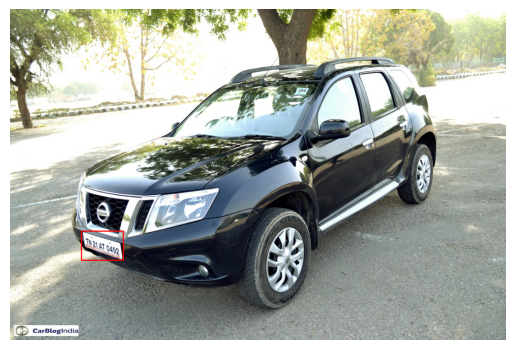

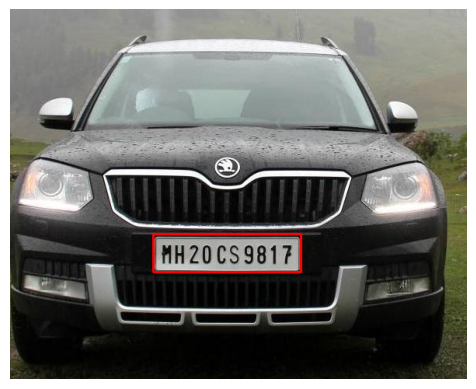

In [7]:
#deal with label paths that end in '.txt.txt'
def clean_label_path(label_path):
    if label_path.endswith('.txt.txt'):
        return label_path.replace('.txt.txt', '.txt')
    return label_path

#show images with boxes
def show_images_with_boxes(image_path, label_path, return_img= False):
  label_path= clean_label_path(label_path)
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _= img.shape

  with open(label_path, 'r') as f:
    boxes= f.readlines()

  for box in boxes:
    class_id, x_center, y_center, box_w, box_h= map(float, box.strip().split())
    x1= int((x_center - box_w / 2) *w)
    y1= int((y_center - box_h / 2) *h)
    x2= int((x_center + box_w / 2) *w)
    y2= int((y_center + box_h / 2) *h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

  if return_img:
    return img
  else:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#show some examples
sample_imgs= sorted(os.listdir(image_dir))[:3]

for img_file in sample_imgs:
  label_file= os.path.splitext(img_file)[0] + '.txt'
  label_path= os.path.join(label_dir, label_file)
  image_path= os.path.join(image_dir, img_file)

  show_images_with_boxes(image_path, label_path)

## Data Exploration

In [8]:
#count the images in each directory
train_imgs= glob('data/archive/images/train/*.jpg')
train_labels= glob('data/archive/labels/train/*.txt')
val_imgs= glob('data/archive/images/val/*.jpg')
val_labels= glob('data/archive/labels/val/*.txt')

print('Train images:', len(train_imgs))
print('Train labels:', len(train_labels))
print('Validation images:', len(val_imgs))
print('Validation labels:', len(val_labels))

Train images: 1526
Train labels: 1526
Validation images: 169
Validation labels: 169


In [9]:
#make sure every image has a matching label file
def check_missing_labels(img_paths, label_dir):
    missing= []
    for img_path in img_paths:
        base= os.path.splitext(os.path.basename(img_path))[0]
        label_path= os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label_path):
            missing.append(img_path)
    return missing

missing_train= check_missing_labels(train_imgs, 'data/archive/labels/train')
missing_val= check_missing_labels(val_imgs, 'data/archive/labels/val')

print(f"Missing labels in training set: {len(missing_train)}")
print(f"Missing labels in validation set: {len(missing_val)}")

Missing labels in training set: 0
Missing labels in validation set: 0


In [10]:
#check out the class distribution to confirm they are all "license plate"
with open("data/archive/classes.txt", "r") as f:
    classes= f.read().splitlines()

print(f"Classes ({len(classes)}): {classes}")

Classes (1): ['license_plate']


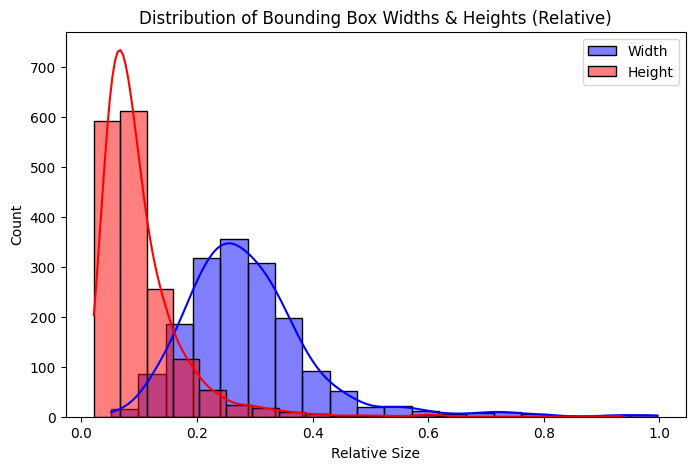

width       height
count  1695.000000  1695.000000
mean      0.288975     0.103054
std       0.117831     0.076331
min       0.051471     0.021452
25%       0.216295     0.057851
50%       0.272059     0.082589
75%       0.337444     0.123077
max       0.996667     0.934483

In [11]:
#check out bounding box size distribution
def get_bbox_dims(label_files):
    widths= []
    heights= []
    for lbl in label_files:
        with open(lbl, 'r') as f:
            for line in f.readlines():
                parts= line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h= map(float, parts)
                    widths.append(w)
                    heights.append(h)
    return pd.DataFrame({'width': widths, 'height': heights})

bbox_df= get_bbox_dims(train_labels + val_labels)

#plot the bounding box distribution
plt.figure(figsize=(8, 5))
sns.histplot(bbox_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(bbox_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Widths & Heights (Relative)")
plt.xlabel("Relative Size")
plt.legend()
plt.show()

bbox_df.describe()

100%|██████████| 1695/1695 [00:00<00:00, 12039.74it/s]


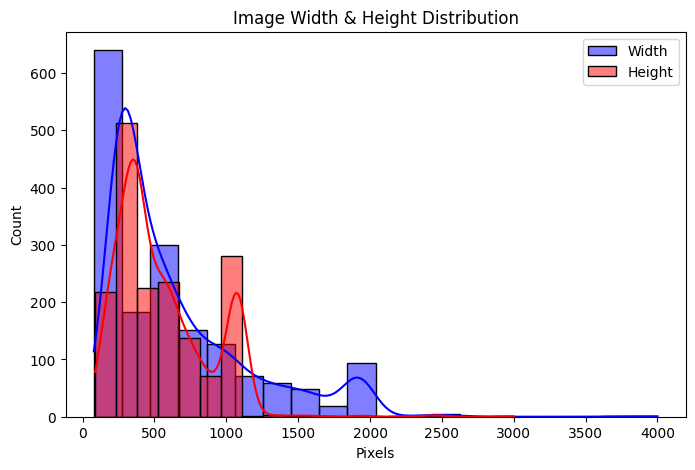

width       height
count  1695.000000  1695.000000
mean    654.546313   554.525664
std     499.585320   321.803263
min      78.000000    87.000000
25%     272.000000   333.000000
50%     485.000000   451.000000
75%     859.500000   734.000000
max    4000.000000  3000.000000

In [12]:
#inspect distribution of image sizes
def get_image_sizes(image_paths):
    widths= []
    heights= []
    for path in tqdm(image_paths):
      with Image.open(path) as img:
        w, h= img.size
        widths.append(w)
        heights.append(h)

    return pd.DataFrame({'width': widths, 'height': heights})

all_imgs= train_imgs + val_imgs
img_dims_df= get_image_sizes(all_imgs)

#print(img_dims_df.describe())

plt.figure(figsize=(8, 5))
sns.histplot(img_dims_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(img_dims_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Image Width & Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()

img_dims_df.describe()

## Data Preprocessing

Letterbox Resizing (padded resize)

In [13]:
#define input and output file paths
input_img_dir= "data/archive/images/train"
input_lbl_dir= "data/archive/labels/train"

output_img_dir= "data/processed/images"
output_lbl_dir= "data/processed/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

In [14]:
#define target dimensions
target_w= 512
target_h= 512

In [15]:
#function to resize the images
def letterbox_resize(image, target_width, target_height):
    h, w= image.shape[:2]
    scale= min(target_width / w, target_height / h)
    new_w= int(w * scale)
    new_h= int(h * scale)

    resized= cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pad_w= target_width - new_w
    pad_h= target_height - new_h
    top= pad_h // 2
    bottom= pad_h - top
    left= pad_w // 2
    right= pad_w - left

    padded= cv2.copyMakeBorder(resized,
                                top,
                                bottom,
                                left,
                                right,
                                cv2.BORDER_CONSTANT,
                                value=(114, 114, 114))

    return padded, scale, left, top, w, h

#function to resize the labels
def process_labels(label_path, scale, pad_left, pad_top, orig_w, orig_h):
    new_lines= []

    with open(label_path, 'r') as f:
        lines= f.readlines()

    for line in lines:
        class_id, x, y, w, h= map(float, line.strip().split())

        #undo YOLO normalization
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h

        #scale
        x *= scale
        y *= scale
        w *= scale
        h *= scale

        #add padding offset
        x += pad_left
        y += pad_top

        #re-normalize
        x /= target_w
        y /= target_h
        w /= target_w
        h /= target_h

        new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    return new_lines

#function to preprocess data subset
def preprocess_yolo_dataset(input_img_dir,
                            input_lbl_dir,
                            output_img_dir,
                            output_lbl_dir,
                            target_w=512,
                            target_h=512):

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_files= [f for f in os.listdir(input_img_dir)
                 if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc=f"Preprocessing {os.path.basename(input_img_dir)}"):
        img_path= os.path.join(input_img_dir, img_file)
        label_filename= os.path.splitext(img_file)[0] + '.txt'
        label_path= os.path.join(input_lbl_dir, label_filename)

        image= cv2.imread(img_path)

        pad_img, scale, pad_left, pad_top, orig_w, orig_h= letterbox_resize(image,
                                                                            target_w,
                                                                            target_h)

        #save the padded image
        out_img_path= os.path.join(output_img_dir, img_file)
        cv2.imwrite(out_img_path, pad_img)

        #process and save image
        if os.path.exists(label_path):
            new_label_lines = process_labels(label_path,
                                             scale,
                                             pad_left,
                                             pad_top,
                                             orig_w,
                                             orig_h)

            out_lbl_path= os.path.join(output_lbl_dir,
                                        label_filename)

            with open(out_lbl_path, 'w') as f:
                f.write('\n'.join(new_label_lines))

In [16]:
#preprocess the train subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/train',
    input_lbl_dir= 'data/archive/labels/train',
    output_img_dir= 'data/processed/images',
    output_lbl_dir= 'data/processed/labels')

#preprocess the validation subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/val',
    input_lbl_dir= 'data/archive/labels/val',
    output_img_dir= 'data/processed_val/images',
    output_lbl_dir= 'data/processed_val/labels')

Preprocessing val: 100%|██████████| 169/169 [00:01<00:00, 136.13it/s]


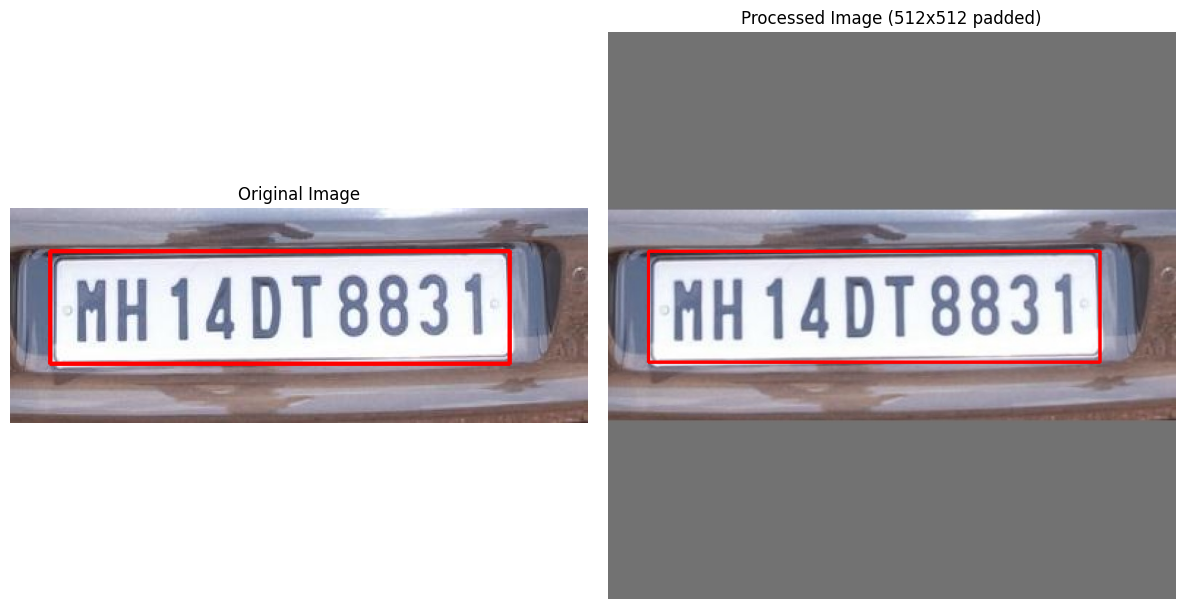

In [17]:
#create function to show image and bounding box before and after transformation
def show_images_side_by_side(img1_path, lbl1_path, img2_path, lbl2_path):
    img1= show_images_with_boxes(img1_path, lbl1_path, return_img=True)
    img2= show_images_with_boxes(img2_path, lbl2_path, return_img=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Processed Image (512x512 padded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#show before and after example from subset of uncomplicated file names
image_files= [f for f in os.listdir(input_img_dir) if f.lower().endswith('.jpg')]
trans_example= sorted(image_files)[8]
#fix label name edge cases
label_filename= os.path.splitext(trans_example)[0] + '.txt'


show_images_side_by_side(os.path.join(input_img_dir, trans_example),
                         os.path.join(input_lbl_dir, label_filename),
                         os.path.join(output_img_dir, trans_example),
                         os.path.join(output_lbl_dir, label_filename))

## Model Building and Data Analysis

### Train-Validation-Test Split

In [18]:
#preprocessed data paths
processed_train_img_dir= 'data/processed/images'
processed_train_lbl_dir= 'data/processed/labels'
processed_val_img_dir= 'data/processed_val/images'
processed_val_lbl_dir= 'data/processed_val/labels'

#output split base directory
split_base= 'data/final_split'
os.makedirs(split_base, exist_ok= True)

#get all preprocessed image-label pairs
train_images= sorted([f for f in os.listdir(processed_train_img_dir)
              if f.endswith('.jpg')])
train_pairs= [(f, os.path.splitext(f)[0] + '.txt') for f in train_images]

#train test split
train_split, test_split= train_test_split(train_pairs,
                                           test_size=0.1,
                                           random_state=24)
#copy image-label pairs to split directories
def copy_split(pairs, dest_split, src_img_dir, src_lbl_dir):
    img_out= os.path.join(split_base, dest_split, 'images')
    lbl_out= os.path.join(split_base, dest_split, 'labels')
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for img_file, lbl_file in tqdm(pairs, desc=f"Copying {dest_split}"):
        shutil.copy(os.path.join(src_img_dir, img_file),
                    os.path.join(img_out, img_file))
        shutil.copy(os.path.join(src_lbl_dir, lbl_file),
                    os.path.join(lbl_out, lbl_file))

#copy final splits
copy_split(train_split, 'train', processed_train_img_dir, processed_train_lbl_dir)
copy_split(test_split, 'test', processed_train_img_dir, processed_train_lbl_dir)

#copy preprocessed validation set as-is
val_pairs= [(f, os.path.splitext(f)[0] + '.txt')
            for f in os.listdir(processed_val_img_dir) if f.endswith('.jpg')]

copy_split(val_pairs, 'val', processed_val_img_dir, processed_val_lbl_dir)

#print the sizes from each split
print("\nTrain size:", len(os.listdir('data/final_split/train/images')))
print("Val size:  ", len(os.listdir('data/final_split/val/images')))
print("Test size: ", len(os.listdir('data/final_split/test/images')))

Copying val: 100%|██████████| 169/169 [00:00<00:00, 5097.28it/s]


Train size: 1373
Val size:   169
Test size:  153


### Create Pytorch Dataset and Dataloader with Transformations

In [19]:
class LicensePlateDataset(Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'

    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [20]:
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform=transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform=transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform=transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

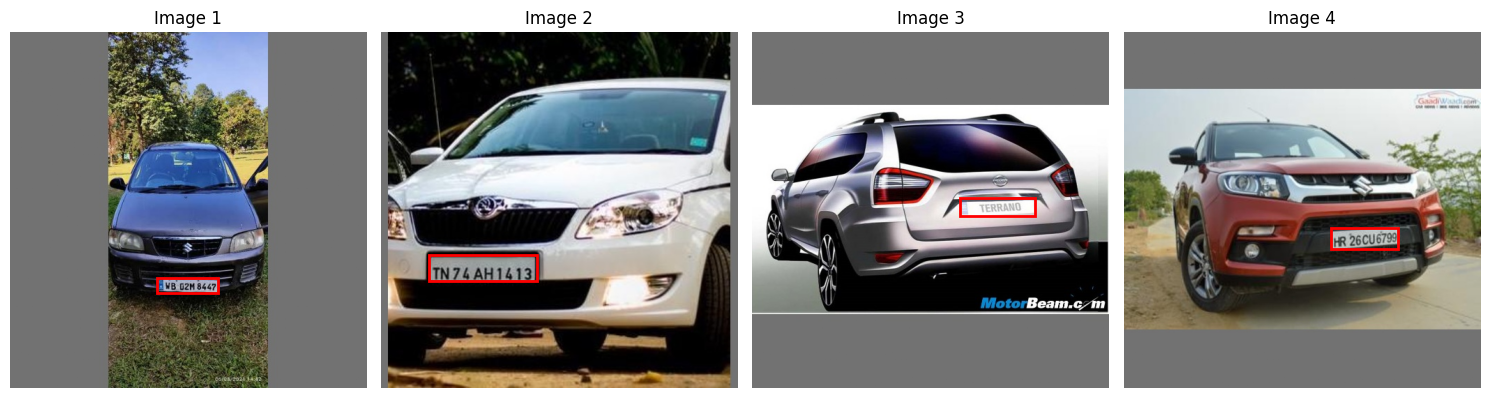

In [21]:
#preview transformed sample with bounding boxes
def show_batch_with_boxes(dataloader, batch_size= 4):
    images, bboxes= next(iter(dataloader))
    images= images[:batch_size]
    bboxes= bboxes[:batch_size]

    fig, axs= plt.subplots(1, batch_size, figsize= (15, 5))

    for i in range(batch_size):
        img= images[i].permute(1, 2, 0).numpy()
        h, w, _= img.shape

        x_center, y_center, box_w, box_h= bboxes[i].tolist()
        x1= int((x_center - box_w / 2) * w)
        y1= int((y_center - box_h / 2) * h)
        x2= int((x_center + box_w / 2) * w)
        y2= int((y_center + box_h / 2) * h)

        axs[i].imshow(img)
        axs[i].add_patch(plt.Rectangle((x1, y1),
                                       x2 - x1,
                                       y2 - y1,
                                       edgecolor='red',
                                       facecolor='none',
                                       linewidth=2))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

show_batch_with_boxes(train_loader, batch_size= 4)

### Analysis Prep

In [22]:
#function to model trainer while optimizing for highest Val
def train_model2(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs=10,
                model_name= 'baseline_model.pth',
                verbose= True):

    best_val_iou= -1.0
    history= {'train_loss': [], 'val_loss': [], 'val_mean_iou': []}

    for epoch in range(epochs):
      if verbose:
        print(f"\nEpoch {epoch+1}/{epochs}")

      model.train()
      train_losses= []

      for images, targets in train_loader:
            images, targets= images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs= model(images)
            loss= criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

      avg_train_loss= np.mean(train_losses)

      #validatiopn
      model.eval()
      val_losses= []
      ious= []


      with torch.no_grad():
            for images, targets in val_loader:
                images, targets= images.to(device), targets.to(device)
                outputs= model(images)
                loss= criterion(outputs, targets)
                val_losses.append(loss.item())
                outputs= outputs.cpu()
                targets= targets.cpu()
                for pred, target in zip(outputs, targets):
                  ious.append(compute_iou(pred, target))

      mean_iou= np.mean(ious)

      avg_val_loss= np.mean(val_losses)

      if verbose:
        print(f"""
Train Loss: {avg_train_loss:.4f}
Val Loss: {avg_val_loss:.4f}
Val IoU {mean_iou: .4f}""")

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)
      history['val_mean_iou'].append(mean_iou)

      #save best model
      if mean_iou > best_val_iou:
        best_val_iou= mean_iou
        torch.save(model.state_dict(), model_name)
        if verbose:
          print(f"Saved new best model (Val IoU = {mean_iou:.4f}): {model_name}")

    return history

In [23]:
#function to plot loss curves
def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
#function to visualize validation predictions
def show_predictions(model, dataloader, device, num_images= 4):
  model.eval()
  images, targets= next(iter(dataloader))
  images, targets= images.to(device), targets.to(device)

  preds= model(images)

  images= images.cpu()
  preds= preds.cpu()
  targets= targets.cpu()

  fig, axes= plt.subplots(1, num_images, figsize= (15, 5))
  for i in range(num_images):
    img= images[i].permute(1, 2, 0).numpy()
    h, w, _= img.shape

    pred_box= preds[i]
    gt_box= targets[i]

    #predicted box
    px1= int((pred_box[0] - pred_box[2] / 2) * w)
    py1= int((pred_box[1] - pred_box[3] / 2) * h)
    px2= int((pred_box[0] + pred_box[2] / 2) * w)
    py2= int((pred_box[1] + pred_box[3] / 2) * h)

    #true box
    gx1= int((gt_box[0] - gt_box[2] / 2) * w)
    gy1= int((gt_box[1] - gt_box[3] / 2) * h)
    gx2= int((gt_box[0] + gt_box[2] / 2) * w)
    gy2= int((gt_box[1] + gt_box[3] / 2) * h)

    axes[i].imshow(img)
    axes[i].add_patch(plt.Rectangle((px1, py1),
                                   px2- px1,
                                   py2- py1,
                                   edgecolor= 'red',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].add_patch(plt.Rectangle((gx1, gy1),
                                   gx2- gx1,
                                   gy2- gy1,
                                   edgecolor= 'green',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

In [25]:
#function to compute IoU for validation set
def compute_iou(box1, box2):
  x1_min= box1[0] - box1[2]/ 2
  x1_max= box1[0] + box1[2]/ 2
  y1_min= box1[1] - box1[3]/ 2
  y1_max= box1[1] + box1[3]/ 2

  x2_min= box2[0] - box2[2]/ 2
  x2_max= box2[0] + box2[2]/ 2
  y2_min= box2[1] - box2[3]/ 2
  y2_max= box2[1] + box2[3]/ 2

  inter_xmin= max(x1_min, x2_min)
  inter_ymin= max(y1_min, y2_min)
  inter_xmax= min(x1_max, x2_max)
  inter_ymax= min(y1_max, y2_max)

  inter_w= max(inter_xmax - inter_xmin, 0)
  inter_h= max(inter_ymax - inter_ymin, 0)
  inter_area= inter_w * inter_h

  area1= (x1_max - x1_min) * (y1_max - y1_min)
  area2= (x2_max - x2_min) * (y2_max - y2_min)

  union_area= area1 + area2 - inter_area

  iou= inter_area / union_area if union_area > 0 else 0
  iou= max(0, min(iou, 1))
  return iou

In [26]:
#function to evaluate iou of model
def evaluate_iou_with_plot(model, loader, device, verbose= True):
  model.eval()
  ious= []

  with torch.no_grad():
    for images, targets in loader:
      images, targets= images.to(device), targets.to(device)
      preds= model(images)
      preds= preds.clone()
      preds[:, 2:]= preds[:, 2:].clamp(min= 1e-6, max= 1.0)
      preds[:, :2]= preds[:, :2].clamp(min= 0.0, max= 1.0)
      preds= preds.cpu()
      targets= targets.cpu()

      for pred, target in zip(preds, targets):
        ious.append(compute_iou(pred, target))

  mean_iou= np.mean(ious)


  print(f"Mean IoU: {mean_iou:.4f}")

  #plot iou histogram
  plt.figure(figsize=(8, 5))
  plt.hist(ious, bins=20, color='skyblue', edgecolor='black')
  plt.title("Distribution of IoU scores on Validation Set")
  plt.xlabel("IoU Score")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()

  #return mean_iou

### Baseline Model

In [27]:
#define baseline cnn model for bounding box regression
class SimpleBBoxCNN(nn.Module):
 def __init__(self):
   super(SimpleBBoxCNN, self).__init__()
   self.conv1= nn.Conv2d(3, 16, kernel_size= 3, stride= 2, padding= 1)
   self.conv2= nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding= 1)
   self.conv3= nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding= 1)
   self.conv4= nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)

   #compress dimension
   self.pool= nn.AdaptiveAvgPool2d((1, 1))
   self.fc= nn.Linear(128, 4)

 def forward(self, x):
   x= F.relu(self.conv1(x))
   x= F.relu(self.conv2(x))
   x= F.relu(self.conv3(x))
   x= F.relu(self.conv4(x))
   x= self.pool(x)
   x= x.view(x.size(0), -1)
   x= self.fc(x)
   x= torch.sigmoid(x)
   return x

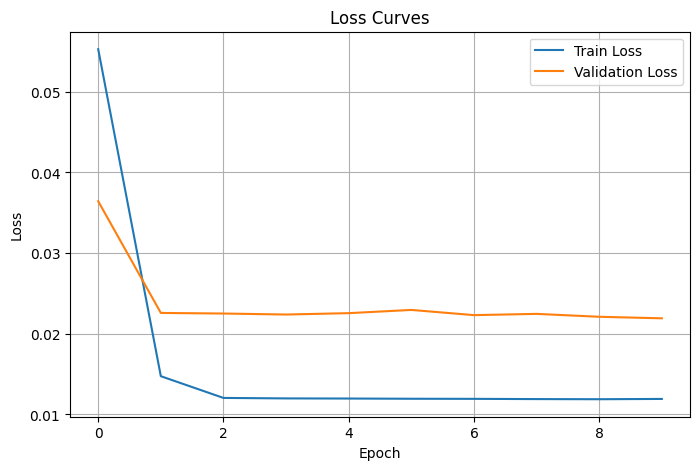

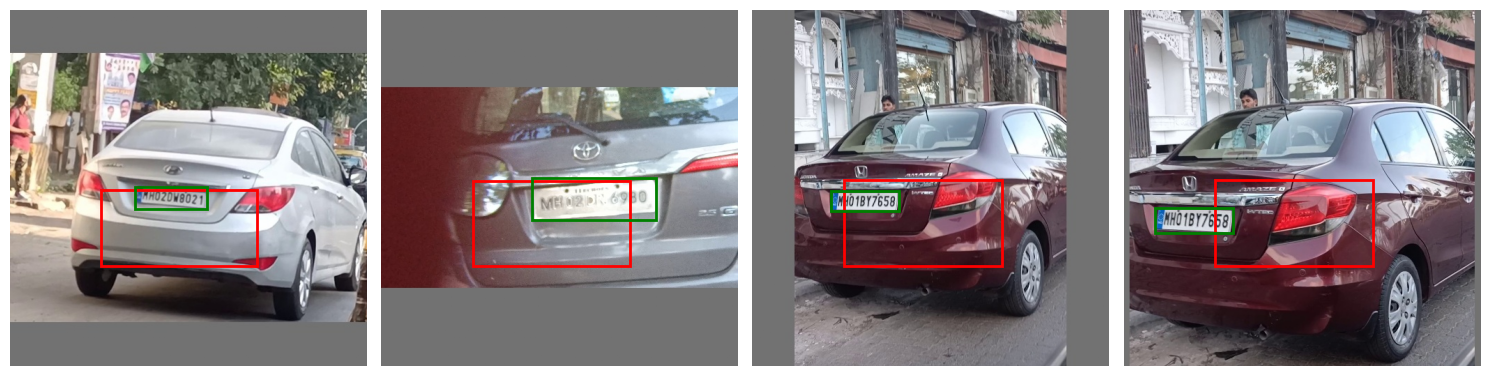

Mean IoU: 0.0698


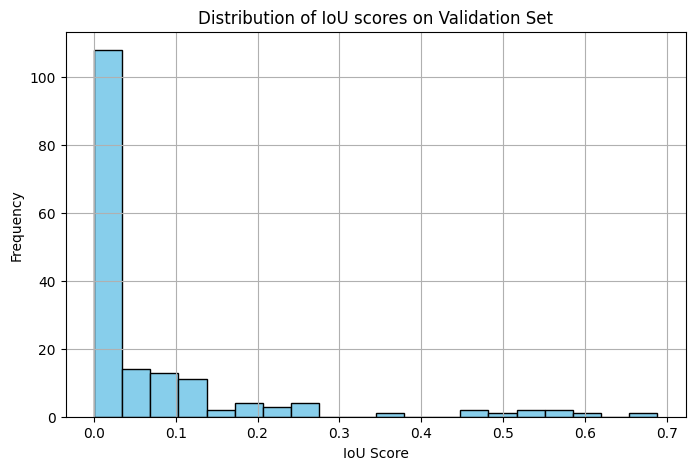

In [28]:
#run the model and evaluate
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model= SimpleBBoxCNN().to(device)
criterion= nn.MSELoss()
optimizer= optim.Adam(baseline_model.parameters(), lr= 0.0001)

history= train_model2(baseline_model,
                     train_loader,
                     val_loader,
                     criterion,
                     optimizer,
                     device,
                     epochs= 10,
                     model_name= 'baseline_model.pth',
                     verbose= False)

plot_loss_curves(history)

#load best model (lowest Val loss)
baseline_model.load_state_dict(torch.load('baseline_model.pth'))
baseline_model.to(device)

#visualize validation predictions
show_predictions(baseline_model, val_loader, device, num_images= 4)

#evaluate the validation set's IoU
evaluate_iou_with_plot(baseline_model, val_loader, device, verbose= False)

### Deeper Model

In [29]:
class DeeperModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(DeeperModel, self).__init__()
        self.conv1= nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1= nn.BatchNorm2d(32)
        self.conv2= nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2= nn.BatchNorm2d(64)
        self.conv3= nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3= nn.BatchNorm2d(128)
        self.conv4= nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4= nn.BatchNorm2d(256)
        self.conv5= nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5= nn.BatchNorm2d(512)

        self.pool= nn.AdaptiveAvgPool2d((1, 1))
        self.dropout= nn.Dropout(dropout_rate)
        self.fc= nn.Linear(512, 4)

    def forward(self, x):
        x= F.relu(self.bn1(self.conv1(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn2(self.conv2(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn3(self.conv3(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn4(self.conv4(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn5(self.conv5(x)))
        x= self.pool(x)

        x= x.view(x.size(0), -1)
        x= self.dropout(x)
        x= self.fc(x)
        x= torch.sigmoid(x)
        return x

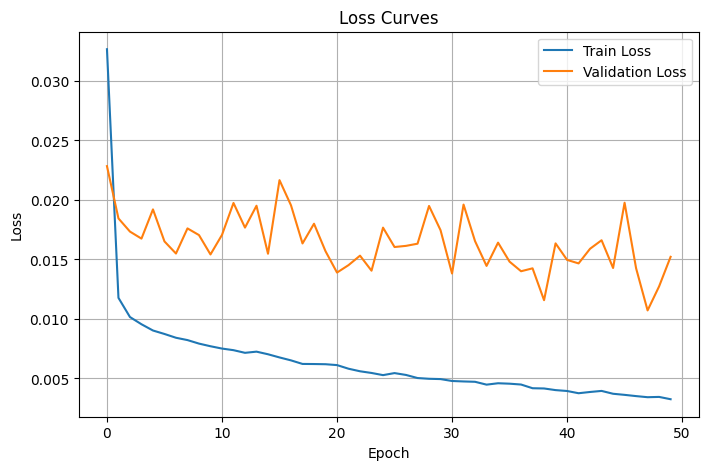

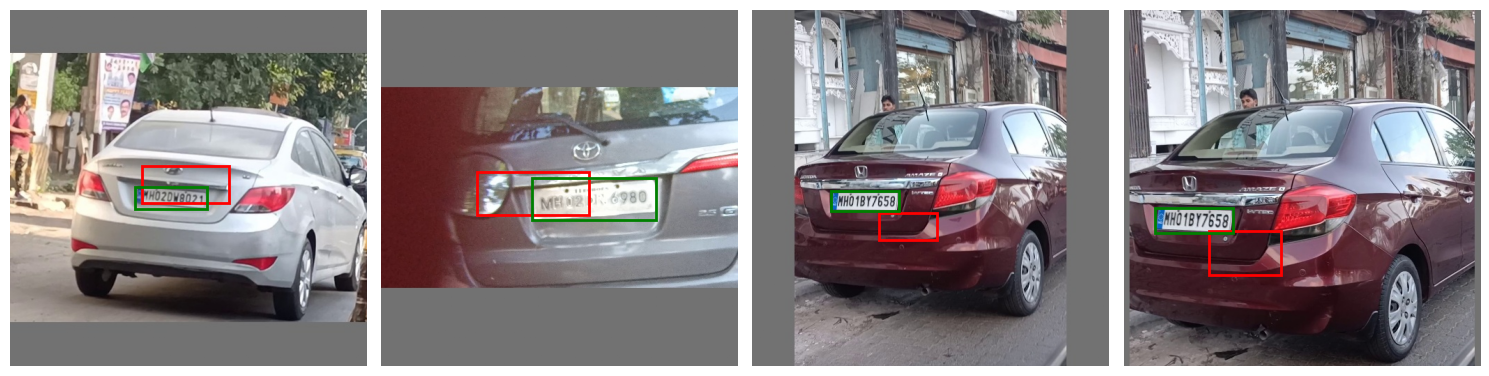

Mean IoU: 0.1225


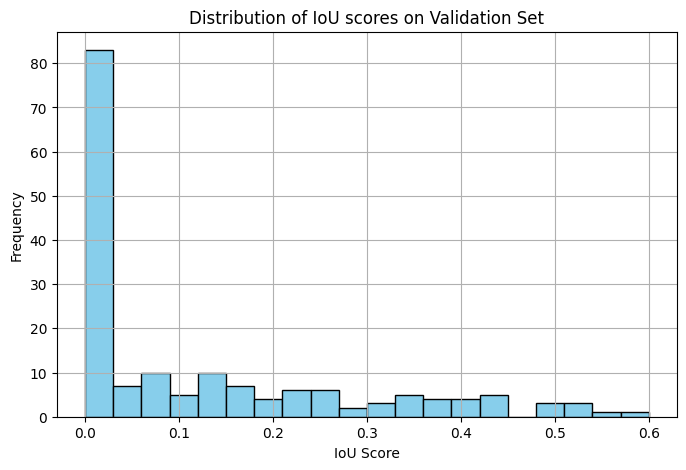

In [30]:
#lets rerun the third model but with these parameters
#instantiate
deeper_model= DeeperModel().to(device)

#optimizer
optimizer= torch.optim.AdamW(deeper_model.parameters(),
                             lr= 0.0001,
                             weight_decay= 0.0)

#loss
criterion= nn.MSELoss()

#train
history_deeper= train_model2(deeper_model,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 50,
                                 model_name= 'deeper_model.pth',
                                 verbose= False)

#plot loss curves
plot_loss_curves(history_deeper)

#load best saved model
deeper_model.load_state_dict(torch.load('deeper_model.pth'))
deeper_model.to(device)

#visualize predictions
show_predictions(deeper_model, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(deeper_model, val_loader, device, verbose= False)

### More Convolutions Model

In [31]:
#Create a third Model
class ThirdModel(nn.Module):
  def __init__(self, dropout_rate= 0.0):
    super(ThirdModel, self).__init__()
    self.conv1= nn.Conv2d(3, 32, kernel_size= 3, padding= 1)
    self.bn1= nn.BatchNorm2d(32)
    self.conv1b= nn.Conv2d(32, 32, kernel_size= 3, padding= 1)
    self.bn1b= nn.BatchNorm2d(32)

    self.conv2= nn.Conv2d(32, 64, kernel_size= 3, padding= 1)
    self.bn2= nn.BatchNorm2d(64)
    self.conv2b= nn.Conv2d(64, 64, kernel_size= 3, padding= 1)
    self.bn2b= nn.BatchNorm2d(64)

    self.conv3= nn.Conv2d(64, 128, kernel_size= 3, padding= 1)
    self.bn3= nn.BatchNorm2d(128)
    self.conv3b= nn.Conv2d(128, 128, kernel_size= 3, padding= 1)
    self.bn3b= nn.BatchNorm2d(128)

    self.conv4= nn.Conv2d(128, 256, kernel_size= 3, padding= 1)
    self.bn4= nn.BatchNorm2d(256)
    self.conv4b= nn.Conv2d(256, 256, kernel_size= 3, padding= 1)
    self.bn4b= nn.BatchNorm2d(256)

    self.conv5= nn.Conv2d(256, 512, kernel_size= 3, padding= 1)
    self.bn5= nn.BatchNorm2d(512)
    self.conv5b= nn.Conv2d(512, 512, kernel_size= 3, padding= 1)
    self.bn5b= nn.BatchNorm2d(512)

    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    self.dropout= nn.Dropout(dropout_rate)
    self.fc= nn.Linear(512, 4)

  def forward(self, x):
    x= F.leaky_relu(self.bn1(self.conv1(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn1b(self.conv1b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn2(self.conv2(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn2b(self.conv2b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn3(self.conv3(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn3b(self.conv3b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn4(self.conv4(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn4b(self.conv4b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn5(self.conv5(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn5b(self.conv5b(x)), negative_slope= 0.1)
    x= self.pool(x)

    x= x.view(x.size(0), -1)
    x= self.dropout(x)
    x= self.fc(x)
    x= torch.sigmoid(x)
    return x

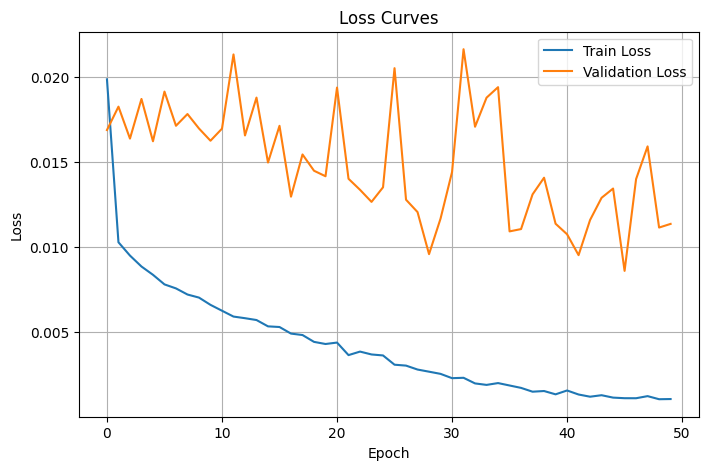

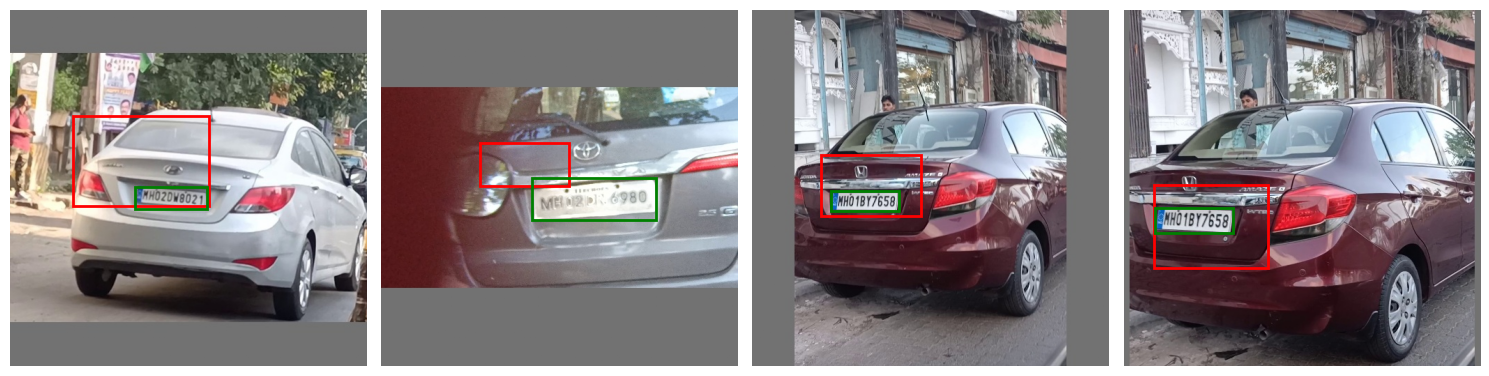

Mean IoU: 0.1354


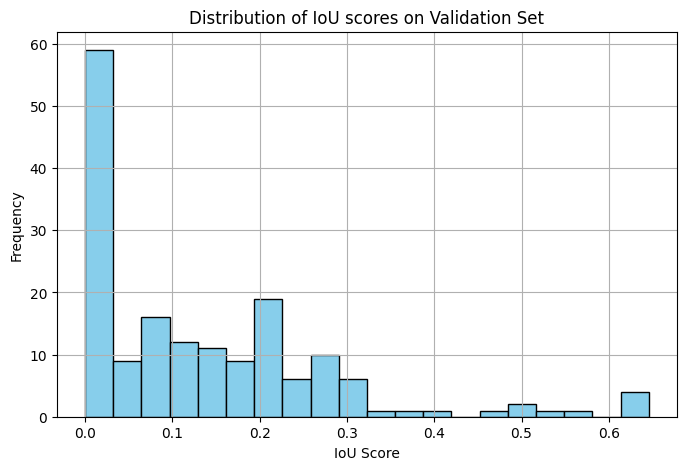

In [32]:
#lets rerun the third model but with these parameters
#instantiate
third_model= ThirdModel().to(device)

#optimizer
optimizer= torch.optim.AdamW(third_model.parameters(),
                             lr= 0.0001,
                             weight_decay= 0.0)

#loss
criterion= nn.MSELoss()

#train
history_third= train_model2(third_model,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 50,
                                 model_name= 'third_model.pth',
                                 verbose= False)

#plot loss curves
plot_loss_curves(history_third)

#load best saved model
third_model.load_state_dict(torch.load('third_model.pth'))
third_model.to(device)

#visualize predictions
show_predictions(third_model, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(third_model, val_loader, device, verbose= False)

Not enough data points to train models, try utilizing transfer learning combined with data augmentation and normalization

### Augment and Normalize Data

In [33]:
#updated transform with augmentation and normalization
transform= transforms.Compose([
    transforms.ColorJitter(brightness= 0.3, contrast= 0.3, saturation= 0.3, hue= 0.1),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.RandomRotation(degrees= 10),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])])

In [34]:
train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform=transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform=transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform=transform)

### Transfer Learning Baseline Model: ReseNet

In [35]:
import torch.nn as nn
import torchvision.models as models

class ResNetBackboneBBoxCNN(nn.Module):
  def __init__(self, dropout= 0.3):
    super(ResNetBackboneBBoxCNN, self).__init__()
    resnet= models.resnet18(pretrained= True)
    self.backbone= nn.Sequential(*list(resnet.children())[:-2])
    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    self.fc= nn.Sequential(nn.Flatten(),
                           nn.Linear(512, 128),
                           nn.ReLU(),
                           nn.Dropout(dropout),
                           nn.Linear(128, 4),
                           nn.Sigmoid())

  def forward(self, x):
    x= self.backbone(x)
    x= self.pool(x)
    x= self.fc(x)
    return x

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


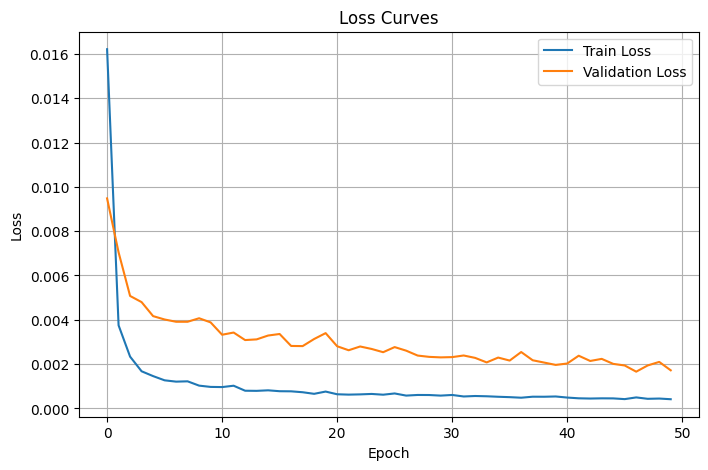

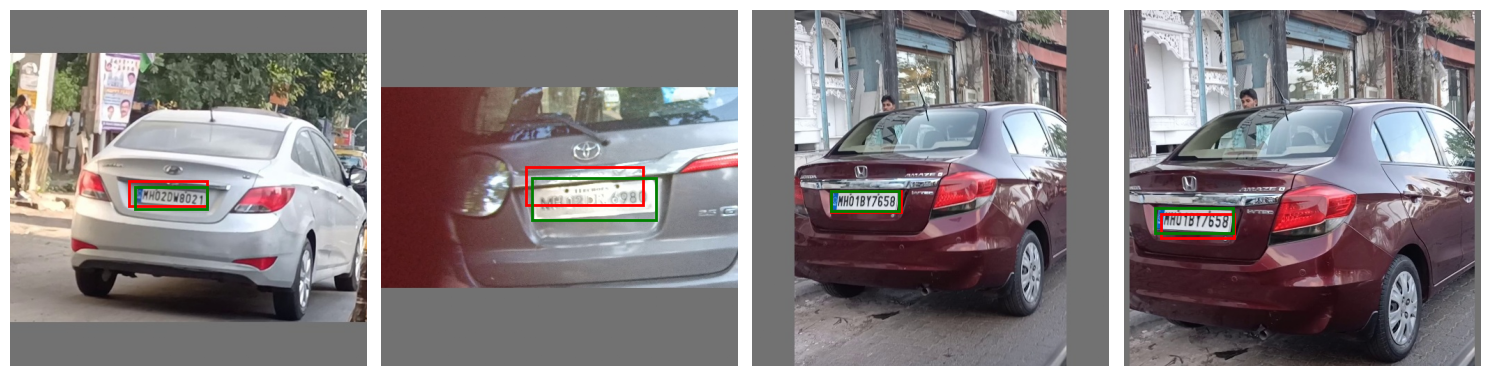

Mean IoU: 0.3839


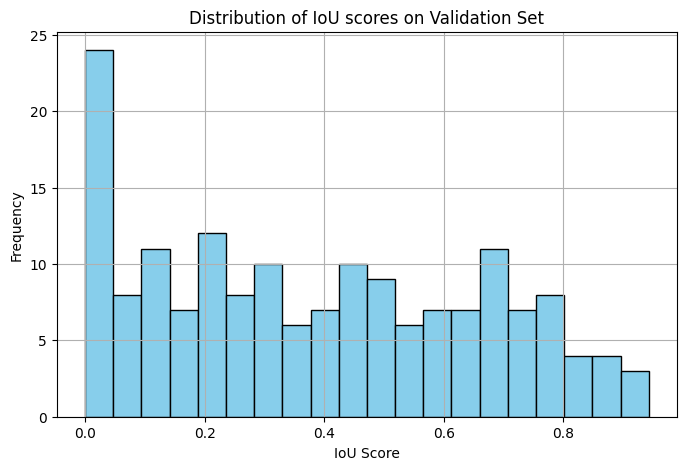

In [36]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model_base= ResNetBackboneBBoxCNN(dropout= 0.1).to(device)
criterion= nn.MSELoss()
optimizer= torch.optim.Adam(transfer_model_base.parameters(), lr= 0.0001)

TB_history= train_model2(transfer_model_base,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs=50,
                      model_name= 'transfer_baseline_model.pth',
                      verbose= False)

transfer_model_base.load_state_dict(torch.load('transfer_baseline_model.pth'))
transfer_model_base.to(device)

plot_loss_curves(TB_history)
show_predictions(transfer_model_base, val_loader, device, num_images=4)
evaluate_iou_with_plot(transfer_model_base, val_loader, device, verbose= False)

Try with alternative loss functions

#### GIOU Loss

In [37]:
def giou_loss(preds, targets):
  def box_cxcywh_to_xyxy(box):
    cx, cy, w, h= box.unbind(-1)
    x1= cx - w / 2
    y1= cy - h / 2
    x2= cx + w / 2
    y2= cy + h / 2
    return torch.stack([x1, y1, x2, y2], dim= -1)

  pred_boxes= box_cxcywh_to_xyxy(preds)
  target_boxes= box_cxcywh_to_xyxy(targets)

  inter_x1= torch.max(pred_boxes[..., 0], target_boxes[..., 0])
  inter_y1= torch.max(pred_boxes[..., 1], target_boxes[..., 1])
  inter_x2= torch.min(pred_boxes[..., 2], target_boxes[..., 2])
  inter_y2= torch.min(pred_boxes[..., 3], target_boxes[..., 3])

  inter_area= (inter_x2 - inter_x1).clamp(min= 0) * (inter_y2 - inter_y1).clamp(min= 0)

  pred_area= (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
  target_area= (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
  union_area= pred_area + target_area - inter_area

  iou= inter_area / (union_area + 1e-7)

  enc_x1= torch.min(pred_boxes[..., 0], target_boxes[..., 0])
  enc_y1= torch.min(pred_boxes[..., 1], target_boxes[..., 1])
  enc_x2= torch.max(pred_boxes[..., 2], target_boxes[..., 2])
  enc_y2= torch.max(pred_boxes[..., 3], target_boxes[..., 3])

  enc_area= (enc_x2 - enc_x1) * (enc_y2 - enc_y1)
  giou= iou - (enc_area - union_area) / (enc_area + 1e-7)
  return 1.0 - giou.mean()

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model_GIOU= ResNetBackboneBBoxCNN(dropout= 0.1).to(device)
criterion= giou_loss
optimizer= torch.optim.Adam(transfer_model_GIOU.parameters(), lr= 0.0001)

TGIOU_history= train_model2(transfer_model_GIOU,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs=50,
                      model_name= 'transfer_GIOU_model.pth',
                      verbose= False)

transfer_model_GIOU.load_state_dict(torch.load('transfer_GIOU_model.pth'))
transfer_model_GIOU.to(device)

plot_loss_curves(TGIOU_history)
show_predictions(transfer_model_GIOU, val_loader, device, num_images=4)
evaluate_iou_with_plot(transfer_model_GIOU, val_loader, device, verbose= False)

#### DIOU Loss

In [ ]:
#diou loss function
def diou_loss(preds, targets):
  def box_cxcywh_to_xyxy(box):
    cx, cy, w, h= box.unbind(-1)
    x1= cx - w / 2
    y1= cy - h / 2
    x2= cx + w / 2
    y2= cy + h / 2
    return torch.stack([x1, y1, x2, y2], dim= -1)

  pred_boxes= box_cxcywh_to_xyxy(preds)
  target_boxes= box_cxcywh_to_xyxy(targets)

  inter_x1= torch.max(pred_boxes[..., 0], target_boxes[..., 0])
  inter_y1= torch.max(pred_boxes[..., 1], target_boxes[..., 1])
  inter_x2= torch.min(pred_boxes[..., 2], target_boxes[..., 2])
  inter_y2= torch.min(pred_boxes[..., 3], target_boxes[..., 3])

  inter_area= (inter_x2 - inter_x1).clamp(min= 0) * (inter_y2 - inter_y1).clamp(min= 0)

  pred_area= (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
  target_area= (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
  union_area= pred_area + target_area - inter_area

  iou= inter_area / (union_area + 1e-7)

  pred_center= (pred_boxes[..., :2] + pred_boxes[..., 2:]) / 2
  target_center= (target_boxes[..., :2] + target_boxes[..., 2:]) / 2
  center_dist= ((pred_center - target_center) ** 2).sum(dim= -1)

  enc_x1= torch.min(pred_boxes[..., 0], target_boxes[..., 0])
  enc_y1= torch.min(pred_boxes[..., 1], target_boxes[..., 1])
  enc_x2= torch.max(pred_boxes[..., 2], target_boxes[..., 2])
  enc_y2= torch.max(pred_boxes[..., 3], target_boxes[..., 3])
  enc_diag= ((enc_x2 - enc_x1) ** 2 + (enc_y2 - enc_y1) **2)

  diou= iou - (center_dist / (enc_diag + 1e-7))
  return 1.0 - diou.mean()

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model_DIOU= ResNetBackboneBBoxCNN(dropout= 0.1).to(device)
criterion= diou_loss
optimizer= torch.optim.Adam(transfer_model_DIOU.parameters(), lr= 0.0001)

TDIOU_history= train_model2(transfer_model_DIOU,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs=50,
                      model_name= 'transfer_DIOU_model.pth',
                      verbose= False)

transfer_model_DIOU.load_state_dict(torch.load('transfer_DIOU_model.pth'))
transfer_model_DIOU.to(device)

plot_loss_curves(TDIOU_history)
show_predictions(transfer_model_DIOU, val_loader, device, num_images=4)
evaluate_iou_with_plot(transfer_model_DIOU, val_loader, device, verbose= False)

#### CIOU Loss

In [ ]:
def ciou_loss(preds, targets):
  def box_cxcywh_to_xyxy(box):
    cx, cy, w, h= box.unbind(-1)
    x1= cx - w / 2
    y1= cy - h / 2
    x2= cx + w / 2
    y2= cy + h / 2
    return torch.stack([x1, y1, x2, y2], dim= -1)

  pred_boxes= box_cxcywh_to_xyxy(preds)
  target_boxes= box_cxcywh_to_xyxy(targets)

  inter_x1= torch.max(pred_boxes[..., 0], target_boxes[..., 0])
  inter_y1= torch.max(pred_boxes[..., 1], target_boxes[..., 1])
  inter_x2= torch.min(pred_boxes[..., 2], target_boxes[..., 2])
  inter_y2= torch.min(pred_boxes[..., 3], target_boxes[..., 3])

  inter_area= (inter_x2 - inter_x1).clamp(min= 0) * (inter_y2 - inter_y1).clamp(min= 0)

  pred_area= (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
  target_area= (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
  union_area= pred_area + target_area - inter_area
  iou= inter_area / (union_area + 1e-7)

  pred_center= (pred_boxes[..., :2] + pred_boxes[..., 2:]) / 2
  target_center= (target_boxes[..., :2] + target_boxes[..., 2:]) / 2
  center_dist= ((pred_center - target_center) ** 2).sum(dim= -1)

  enc_x1= torch.min(pred_boxes[..., 0], target_boxes[..., 0])
  enc_y1= torch.min(pred_boxes[..., 1], target_boxes[..., 1])
  enc_x2= torch.max(pred_boxes[..., 2], target_boxes[..., 2])
  enc_y2= torch.max(pred_boxes[..., 3], target_boxes[..., 3])
  enc_diag= ((enc_x2 - enc_x1) ** 2 + (enc_y2 - enc_y1) ** 2) + 1e-7

  pred_w= pred_boxes[..., 2] - pred_boxes[..., 0]
  pred_h= pred_boxes[..., 3] - pred_boxes[..., 1]
  target_w= target_boxes[..., 2] - target_boxes[..., 0]
  target_h= target_boxes[..., 3] - target_boxes[..., 1]

  v= (4 / (math.pi ** 2)) * (torch.atan(target_w / (target_h + 1e-7)) - torch.atan(pred_w / (pred_h + 1e-7))) ** 2
  with torch.no_grad():
    alpha= v / (1 - iou + v + 1e-7)

  ciou= iou - (center_dist / enc_diag) - alpha * v
  return 1.0 - ciou.mean()

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model_CIOU= ResNetBackboneBBoxCNN(dropout= 0.1).to(device)
criterion= ciou_loss
optimizer= torch.optim.Adam(transfer_model_CIOU.parameters(), lr= 0.0001)

TCIOU_history= train_model2(transfer_model_CIOU,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs=50,
                      model_name= 'transfer_CIOU_model.pth',
                      verbose= False)

transfer_model_CIOU.load_state_dict(torch.load('transfer_CIOU_model.pth'))
transfer_model_CIOU.to(device)

plot_loss_curves(TCIOU_history)
show_predictions(transfer_model_CIOU, val_loader, device, num_images=4)
evaluate_iou_with_plot(transfer_model_CIOU, val_loader, device, verbose= False)

#### Grid Search the Transfer Model with the best Loss Function

In [ ]:
#parameter grid
dropout_vals= [0, 0.1, 0.3]
lr_vals= [1e-4, 3e-4, 1e-3]
wd_vals= [0, 1e-4, 1e-3]
grid= list(itertools.product(dropout_vals, lr_vals, wd_vals))

#storage for results
results= []

#loop through combinations
for dropout, lr, wd in grid:
  #print(f"\nTraining model with dropout= {dropout}, lr= {lr}, weight_decay= {wd}")
  device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model= ResNetBackboneBBoxCNN(dropout= dropout).to(device)
  optimizer= optim.Adam(model.parameters(), lr= lr, weight_decay= wd)

  history = train_model2(model,
                         train_loader,
                         val_loader,
                         criterion= diou_loss,
                         optimizer= optimizer,
                         device= device,
                         epochs= 15,
                         model_name= 'temp_model.pth',
                         verbose= False)

  best_iou= max(history['val_mean_iou']) if history['val_mean_iou'] else 0
  results.append({'dropout': dropout,
                  'lr': lr,
                  'weight_decay': wd,
                  'val_mean_iou': best_iou})

#display results
results_df= pd.DataFrame(results)
print("Grid Search Results:")
print(results_df.sort_values(by= 'val_mean_iou', ascending= False))

run the DIOU transfer model with best parameters for 50 epochs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tuned_DIOU_transfer = ResNetBackboneBBoxCNN(dropout=0.0).to(device)
criterion = diou_loss
optimizer = torch.optim.Adam(tuned_DIOU_transfer.parameters(), lr=0.0003, weight_decay=0.0)

TD_history = train_model2(tuned_DIOU_transfer,
                       train_loader,
                       val_loader,
                       criterion,
                       optimizer,
                       device,
                       epochs=50,
                       model_name='tuned_DIOU_transfer_model.pth',
                       verbose= False)

tuned_DIOU_transfer.load_state_dict(torch.load('tuned_DIOU_transfer_model.pth'))
tuned_DIOU_transfer.to(device)

plot_loss_curves(TD_history)
show_predictions(tuned_DIOU_transfer, val_loader, device, num_images=4)
evaluate_iou_with_plot(tuned_DIOU_transfer, val_loader, device, verbose= False)

## Final Test

In [ ]:
#load in the final test data
val_transform = transforms.ToTensor()

test_dataset= LicensePlateDataset(image_dir= 'data/final_split/test/images',
                                  label_dir= 'data/final_split/test/labels',
                                  transform= val_transform)
test_loader= DataLoader(test_dataset, batch_size= 16, shuffle= False)

In [ ]:
#run predictions on evaluation test set
#make sure model is in evaluation mode and on correct device
tuned_DIOU_transfer.eval()
tuned_DIOU_transfer.to(device)

#visualize predictions
show_predictions(tuned_DIOU_transfer, test_loader, device, num_images= 4)

#compute and print IOU
evaluate_iou_with_plot(tuned_DIOU_transfer, test_loader, device, verbose= False)